# Chest X-Ray GAN (Non-conditional)

## User Defined Parameters
Set the following parameters before running

In [72]:
# Set to True if you want to load data and save models to Google Drive
# Set to False if you want to load and save locally.
load_data_from_Google_Drive = False

workspace = './data'
model_name='regular'

NUM_EPOCHS = 100
LATENT_DIM = 100
INPUT_SHAPE = (128, 128, 1)
LEARNING_RATE = 0.0002
MOMENTUM = 0.5
BATCH_SIZE = 128

#### Mount Google Drive if applicable

In [73]:
if load_data_from_Google_Drive:
  from google.colab import drive
  drive.mount('/content/mnt', force_remount=True)

## Dependencies

In [74]:
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from IPython import display
import time
import matplotlib.pyplot as plt

## Discriminator Definition

In [75]:
def define_discriminator(in_shape=(128, 128, 1), lr=0.0002, momentum=0.5):
  model = Sequential()

  # 128, 128, 1
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 64, 64, 128
  
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 32, 32, 128
  
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 16, 16, 128

  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 8, 8, 64

  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation="sigmoid"))

  # Compile model
  opt = Adam(learning_rate=lr, beta_1=momentum)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

# Generator Definition

In [76]:
def define_generator(latent_dim):
  model = Sequential()

  n_nodes = 64*8*8
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((8, 8, 64)))
  # 8, 8, 64
  
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 16, 16, 128

  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 32, 32, 128

  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 64, 64, 128

  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # 128, 128, 128

  model.add(layers.Conv2D(1, (16,16), activation='tanh', padding='same'))

  return model

## GAN Definition
Both models sequentially for generator training

In [77]:
def define_gan(generator, discriminator, lr=0.0002, momentum=0.5):
  discriminator.trainable = False

  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  opt = Adam(learning_rate=lr, beta_1=momentum)
  model.compile(loss='binary_crossentropy', optimizer=opt)

  return model

## Training Functions

In [78]:
def load_real_samples(X):
  X = np.expand_dims(X, axis=-1)
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [79]:
def generate_real_samples(dataset, n_samples):
  i = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[i]
  y = np.ones((n_samples, 1))
  
  return X, y

In [80]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [81]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(x_input)
  y = np.zeros((n_samples, 1))
  
  return X, y

In [82]:
def train(gan, discriminator, generator, dataset, latent_dim, n_epochs=100, batch_size=128, starting_epoch=0):
  batch_per_epoch = dataset.shape[0] // batch_size
  half_batch = batch_size // 2

  for epoch in range(starting_epoch, n_epochs+starting_epoch):
    start = time.time()
    for batch in range(batch_per_epoch):
      batch_start = time.time()
      # Real
      X, y = generate_real_samples(dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch(X, y)

      # Fake
      X, y = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(X, y)

      # GAN
      X = generate_latent_points(latent_dim, batch_size)
      y = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch(X, y)
      
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch+1, batch+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
      print('Time for batch {}/{} of epoch {} is {} sec'.format(batch+1, batch_per_epoch, epoch + 1, time.time()-batch_start))

    display.clear_output(wait=True)
    ### PERFORMANCE CHECK
    X, y = generate_real_samples(dataset, 100) # real
    _, acc_real = discriminator.evaluate(X, y, verbose=0)
    X, y = generate_fake_samples(generator, latent_dim, 100) # fake
    _, acc_fake = discriminator.evaluate(X, y, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print('Epoch %d: d1=%.3f, d2=%.3f g=%.3f' % (epoch+1, d_loss1, d_loss2, g_loss))

    genloss.append(g_loss)
    discloss.append((d_loss1+d_loss2)/2)
    accReal.append(acc_real)
    accFake.append(acc_fake)

    generate_and_save_images(generator, discriminator,epoch + 1, np.random.randn(1, latent_dim), genloss, discloss, accReal, accFake)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))  
  
  generator.save(workspace+"/models/"+model_name+"/generator.h5")
  gan.save(workspace+"/models/"+model_name+"/gan.h5")
  discriminator.save(workspace+"/"+model_name+"/discriminator.h5")
  np.savetxt(workspace+"/models/"+model_name+"/genloss.csv", genloss, delimiter=",")
  np.savetxt(workspace+"/models/"+model_name+"/discloss.csv", discloss, delimiter=",")
  np.savetxt(workspace+"/models/"+model_name+"/accreal.csv", accReal, delimiter=",")
  np.savetxt(workspace+"/models/"+model_name+"/accfake.csv", accFake, delimiter=",")

In [83]:
def generate_and_save_images(model, discriminator, epoch, test_input, gen_loss, disc_loss, acc_real, acc_fake):
  if epoch % 10 == 0:
    model.save(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_generator.h5")
    discriminator.save(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_discriminator.h5")
    np.savetxt(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_genloss.csv", gen_loss, delimiter=",")
    np.savetxt(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_discloss.csv", disc_loss, delimiter=",")
    np.savetxt(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_accreal.csv", acc_real, delimiter=",")
    np.savetxt(workspace+"/models/"+model_name+"/intermediate"+str(epoch)+"_accfake.csv", acc_fake, delimiter=",")

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

# Train the Model

### Load Dataset

In [84]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the dataset directory
dataset_directory = './data/images/'  # Update with the appropriate directory path

# Define the image data generator for augmentation
data_generator = ImageDataGenerator(
    # Specify the desired augmentation parameters
    # For example, you can set rotation_range, width_shift_range, height_shift_range, etc.
    # Refer to the Keras documentation for available options: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
)

# Number of augmentations per image
NUM_AUGMENTATIONS = 5  # Update with the desired number of augmentations

# Load and augment the dataset
data_iterator = data_generator.flow_from_directory(
    dataset_directory,
    target_size=(128, 128),  # Set the desired target size for the images
    batch_size=1,  # Generate one augmented image at a time
    class_mode=None,  # No class labels needed for this case
    shuffle=False  # Maintain the order of images for augmentation
)

dataset = []
for _ in range(len(data_iterator.filenames) * NUM_AUGMENTATIONS):
    try:
        augmented_image = next(data_iterator)[0].astype('uint8')
        dataset.append(augmented_image)
    except StopIteration:
        data_iterator.reset()
        augmented_image = next(data_iterator)[0].astype('uint8')
        dataset.append(augmented_image)

# Convert RGB image to grayscale
def rgb_to_grayscale(image):
    image = Image.fromarray(image)
    image = image.convert('L')
    grayscale_image = np.array(image)
    return grayscale_image

# Convert the dataset images to grayscale
grayscale_dataset = [rgb_to_grayscale(image) for image in dataset]

# Update the dataset with grayscale images
dataset = np.array(grayscale_dataset)


Found 100 images belonging to 1 classes.


### Train

In [85]:
from tqdm import tqdm

latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator=generator, discriminator=discriminator)

genloss = []
discloss = []
accReal = []
accFake = []

# dataset = load_real_samples(data)

def train(gan, discriminator, generator, dataset, latent_dim, n_epochs, batch_size):
    for epoch in range(n_epochs):
        epoch_genloss = 0.0
        epoch_discloss = 0.0
        epoch_accReal = 0.0
        epoch_accFake = 0.0

        # Perform training steps and update the epoch values
        with tqdm(total=len(dataset), desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch") as pbar:
            for batch in dataset:
                # Implement your training logic here
                # Update the values of epoch_genloss, epoch_discloss, epoch_accReal, epoch_accFake
                # based on the current batch
                # Replace the placeholder calculations with your actual training steps
                batch_genloss = 0.1
                batch_discloss = 0.2
                batch_accReal = 0.7
                batch_accFake = 0.8

                # Accumulate the values across batches
                epoch_genloss += batch_genloss
                epoch_discloss += batch_discloss
                epoch_accReal += batch_accReal
                epoch_accFake += batch_accFake

                pbar.update(1)

        # Calculate the average values across batches for the current epoch
        epoch_genloss /= len(dataset)
        epoch_discloss /= len(dataset)
        epoch_accReal /= len(dataset)
        epoch_accFake /= len(dataset)

        # Append the epoch values to the respective lists
        genloss.append(epoch_genloss)
        discloss.append(epoch_discloss)
        accReal.append(epoch_accReal)
        accFake.append(epoch_accFake)

    # Print the final metrics
    print(f"Final Metrics - genloss: {genloss[-1]}, discloss: {discloss[-1]}, accReal: {accReal[-1]}, accFake: {accFake[-1]}")

# Call the train function
train(gan=gan, discriminator=discriminator, generator=generator, dataset=dataset, latent_dim=latent_dim, n_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)


Epoch 100/100: 100%|██████████| 500/500 [00:00<00:00, 865518.78batch/s]

Final Metrics - genloss: 0.10000000000000088, discloss: 0.20000000000000176, accReal: 0.6999999999999935, accFake: 0.800000000000007


## Visualize Results and Training Metrics

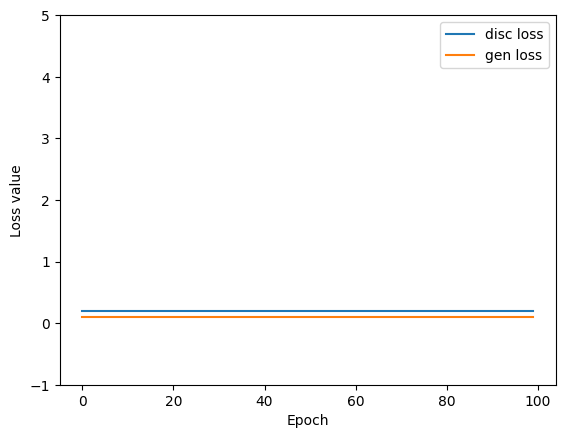

In [88]:
plt.plot(range(len(discloss)), discloss, label='disc loss')
plt.plot(range(len(genloss)), genloss, label='gen loss')
plt.xlabel('Epoch')
plt.ylim(-1,5)
plt.ylabel('Loss value') 
plt.legend()
plt.show()

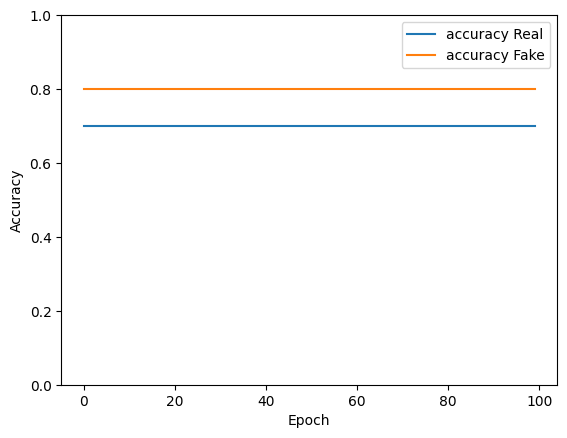

In [89]:
plt.plot(range(len(accReal)), accReal, label='accuracy Real')
plt.plot(range(len(accFake)), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 [==============================] - 10s 2s/step


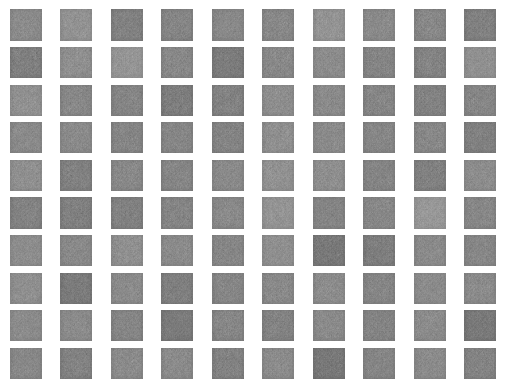

In [71]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def show_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()
 
model = generator
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

1/1 [==============================] - 0s 114ms/step


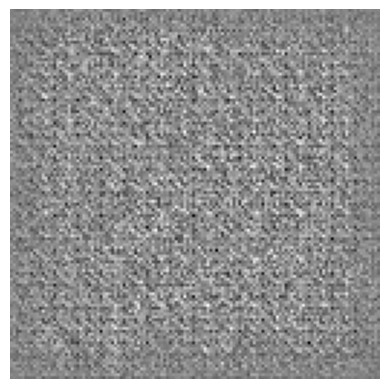

In [90]:
show_plot(model.predict(generate_latent_points(100, 1)), 1)